In [1]:
import os
os.chdir("..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob

# customized keras_preprocessing.image in preprocess_image.py
# u_net in the network.py
# mean_iou metric in metrics.py
# predict_mask in utils.py

from lib import *

%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
import sys
import random

In [4]:
import warnings
# block tensorflow~numpy warnings
warnings.filterwarnings('ignore')

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Задача

**Требуется:** предложить модель, сегментирующую человека на фотографии.  
  
**Вход:** фотография 320x240x3.  
**Выход:** маска человека 320x240.  
**Метрика:** [Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient).  
  
  
Данные представляют из себя набор фотографий человека и маски, определяющей положение человека на фотографии.  
Доступные данные разделены на несколько папок:  
- `train` содержит фотографии 320x240x3;
- `train_mask` содержит маски для фотографий из `train` 320x240;
- `valid` содержит фотографии 320x240x3;
- `valid_mask` содержит маски для фотографий из `valid` 320x240;
- `test` содержит фотографии 320x240x3.  
  
Для лучшей модели требуется создать 2 файла, которые необходимы для валидации Вашего решения:  
- сохраненные маски для картинок из `valid` в формате `pred_valid_template.csv`;
- html страницу с предсказанием модели для всех картинок из `test` и папку с используемыми картинками в этой html странице.  
  
Также необходимо:
- подготовить код для проверки (докстринги, PEP8);
- создать отчет (можно прямо в ноутбуке) с описанием Вашего исследования, гипотез и т.п.

Примеры приведены ниже.

---

# Environment

In [5]:
BATCH_SIZE = 10 
# memory issues on 8 gig memory container
IMG_WIDTH = 240
IMG_HEIGHT = 240
IMG_CHANNELS = 3

TRAIN_PATH = 'data/train'
TRAIN_MASK_PATH = 'data/train_mask'

VALIDATE_PATH = 'data/valid'
VALIDATE_MASK_PATH = 'data/valid_mask'

TEST_PATH = 'data/test'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 83

images = os.listdir(TRAIN_PATH)
val_images = os.listdir(VALIDATE_PATH)
test_images = os.listdir(TEST_PATH)


# Данные

Посмотрим на данные:

In [6]:
# get_xy reshapes the images to 240 * 240 

X_train, Y_train = get_xy(images, TRAIN_PATH, TRAIN_MASK_PATH)
X_validate, Y_validate = get_xy(val_images, VALIDATE_PATH, VALIDATE_MASK_PATH)
X_test, Y_test_placeholder = get_xy(test_images, TEST_PATH)

In [7]:
random_index = np.random.choice(X_train.shape[0])

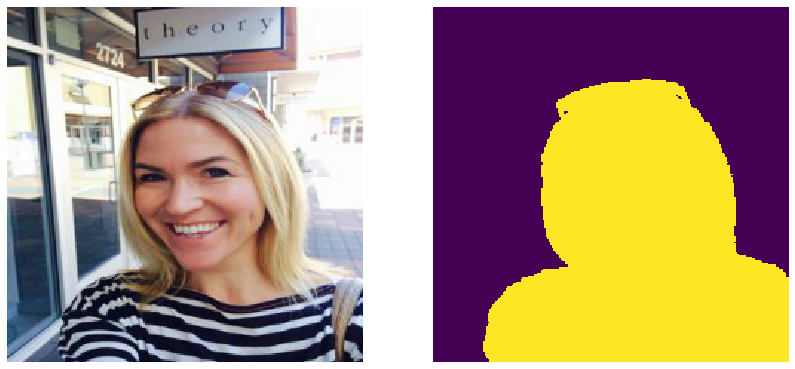

In [8]:
show_img_with_mask(X_train[random_index], Y_train[random_index][:,:,0])

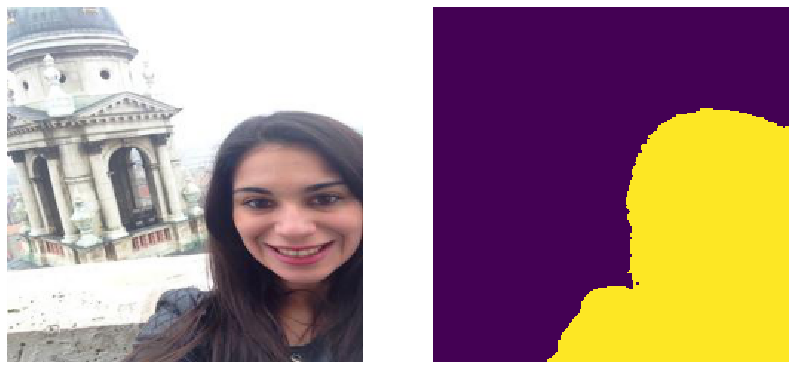

In [9]:
random_index = np.random.choice(X_validate.shape[0])
show_img_with_mask(X_validate[random_index], Y_validate[random_index][:,:,0])

# Preprocessing

## data augmentation

In [10]:
# apply shear, rotation, zoom, shift, fillcontrast and contrast_stretching to augment train

image_datagen = preprocess_image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', contrast_stretching=True)
mask_datagen = preprocess_image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', contrast_stretching=True)

image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(Y_train, augment=True, seed=seed)

x=image_datagen.flow(X_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train,batch_size=BATCH_SIZE,shuffle=True, seed=seed)



In [11]:
# augment valiadation images 
image_datagen = preprocess_image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', contrast_stretching=True)
mask_datagen = preprocess_image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect', contrast_stretching=True)

image_datagen.fit(X_validate, augment=True, seed=seed)
mask_datagen.fit(Y_validate, augment=True, seed=seed)

x_val=image_datagen.flow(X_validate,batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen.flow(Y_validate,batch_size=BATCH_SIZE,shuffle=True, seed=seed)

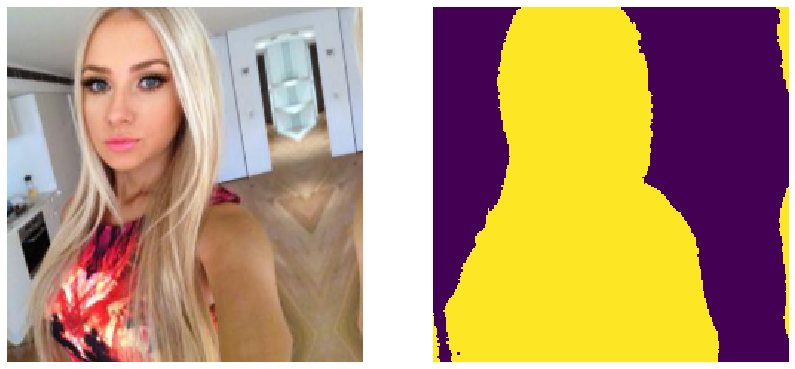

In [12]:
show_img_with_mask(x.next()[0].astype(np.uint8), np.squeeze(y.next()[0].astype(np.uint8)))

In [13]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

## compile u-net

In [14]:
model = u_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 240, 240, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 

## train u-net

In [15]:
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model-segmentation-3.2.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=15, callbacks=[earlystopper, checkpointer])

Epoch 1/15
250/250 [==============================] - 2403s 10s/step - loss: 0.5832 - mean_iou: 0.3507 - val_loss: 0.6820 - val_mean_iou: 0.4070

Epoch 00001: val_loss improved from inf to 0.68198, saving model to model-segmentation-3.2.h5
Epoch 2/15
250/250 [==============================] - 1440s 6s/step - loss: 0.5005 - mean_iou: 0.4303 - val_loss: 0.5268 - val_mean_iou: 0.4488

Epoch 00002: val_loss improved from 0.68198 to 0.52682, saving model to model-segmentation-3.2.h5
Epoch 3/15
250/250 [==============================] - 1830s 7s/step - loss: 0.4768 - mean_iou: 0.4620 - val_loss: 0.4682 - val_mean_iou: 0.4720

Epoch 00003: val_loss improved from 0.52682 to 0.46819, saving model to model-segmentation-3.2.h5
Epoch 4/15
250/250 [==============================] - 1590s 6s/step - loss: 0.4465 - mean_iou: 0.4817 - val_loss: 0.4305 - val_mean_iou: 0.4906

Epoch 00004: val_loss improved from 0.46819 to 0.43050, saving model to model-segmentation-3.2.h5
Epoch 5/15
250/250 [===========

In [16]:
checkpointer = ModelCheckpoint('model-segmentation-3.2.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=5, callbacks=[earlystopper, checkpointer])

Epoch 1/5
250/250 [==============================] - 1238s 5s/step - loss: 0.2988 - mean_iou: 0.6105 - val_loss: 0.9373 - val_mean_iou: 0.6139

Epoch 00001: val_loss improved from inf to 0.93731, saving model to model-segmentation-3.2.h5
Epoch 2/5
250/250 [==============================] - 1231s 5s/step - loss: 0.2569 - mean_iou: 0.6172 - val_loss: 0.3001 - val_mean_iou: 0.6207

Epoch 00002: val_loss improved from 0.93731 to 0.30012, saving model to model-segmentation-3.2.h5
Epoch 3/5
250/250 [==============================] - 1227s 5s/step - loss: 0.2465 - mean_iou: 0.6241 - val_loss: 0.2208 - val_mean_iou: 0.6275

Epoch 00003: val_loss improved from 0.30012 to 0.22084, saving model to model-segmentation-3.2.h5
Epoch 4/5
250/250 [==============================] - 1223s 5s/step - loss: 0.2384 - mean_iou: 0.6309 - val_loss: 0.2577 - val_mean_iou: 0.6340

Epoch 00004: val_loss did not improve from 0.22084
Epoch 5/5
250/250 [==============================] - 1228s 5s/step - loss: 0.2216 -

In [17]:
checkpointer = ModelCheckpoint('model-segmentation-3.2.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=15, callbacks=[earlystopper, checkpointer])

Epoch 1/15
250/250 [==============================] - 1228s 5s/step - loss: 0.2716 - mean_iou: 0.6422 - val_loss: 1.2271 - val_mean_iou: 0.6447

Epoch 00001: val_loss improved from inf to 1.22711, saving model to model-segmentation-3.2.h5
Epoch 2/15
250/250 [==============================] - 1220s 5s/step - loss: 0.2239 - mean_iou: 0.6473 - val_loss: 0.2650 - val_mean_iou: 0.6501

Epoch 00002: val_loss improved from 1.22711 to 0.26498, saving model to model-segmentation-3.2.h5
Epoch 3/15
250/250 [==============================] - 1241s 5s/step - loss: 0.2174 - mean_iou: 0.6528 - val_loss: 0.2324 - val_mean_iou: 0.6554

Epoch 00003: val_loss improved from 0.26498 to 0.23244, saving model to model-segmentation-3.2.h5
Epoch 4/15
250/250 [==============================] - 1496s 6s/step - loss: 0.2130 - mean_iou: 0.6580 - val_loss: 0.2257 - val_mean_iou: 0.6605

Epoch 00004: val_loss improved from 0.23244 to 0.22565, saving model to model-segmentation-3.2.h5
Epoch 5/15
250/250 [============

In [ ]:
checkpointer = ModelCheckpoint('model-segmentation-3.2.h5', verbose=1, save_best_only=True)
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=15, callbacks=[earlystopper, checkpointer])

Epoch 1/15
250/250 [==============================] - 1219s 5s/step - loss: 0.2406 - mean_iou: 0.6874 - val_loss: 1.2076 - val_mean_iou: 0.6889

Epoch 00001: val_loss improved from inf to 1.20755, saving model to model-segmentation-3.2.h5
Epoch 2/15
250/250 [==============================] - 1295s 5s/step - loss: 0.1838 - mean_iou: 0.6906 - val_loss: 0.2695 - val_mean_iou: 0.6924

Epoch 00002: val_loss improved from 1.20755 to 0.26954, saving model to model-segmentation-3.2.h5
Epoch 3/15
250/250 [==============================] - 1866s 7s/step - loss: 0.1830 - mean_iou: 0.6942 - val_loss: 0.2194 - val_mean_iou: 0.6959

Epoch 00003: val_loss improved from 0.26954 to 0.21936, saving model to model-segmentation-3.2.h5
Epoch 4/15
 71/250 [=======>......................] - ETA: 16:52 - loss: 0.1890 - mean_iou: 0.6965